To run this example locally, [install Ploomber](https://ploomber.readthedocs.io/en/latest/get-started/install.html) and execute: `ploomber examples -n guides/spec-api-python`

To start a free, hosted JupyterLab: [![binder-logo](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ploomber/binder-env/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Fploomber%252Fprojects%26urlpath%3Dlab%252Ftree%252Fprojects%252Fguides/spec-api-python%252FREADME.ipynb%26branch%3Dmaster)

Found an issue? [Let us know.](https://github.com/ploomber/projects/issues/new?title=guides/spec-api-python%20issue)

Have questions? [Ask us anything on Slack.](http://community.ploomber.io/)



# Your first Python pipeline

<!-- start description -->
Introductory tutorial to learn the basics of Ploomber.
<!-- end description -->

**Note:** This is intended for a quick and interactive experience. If you want
to learn about Ploomber's core concepts and design rationale, go to the
[the next tutorial](https://ploomber.readthedocs.io/en/latest/get-started/basic-concepts.html).

## Why Ploomber?

**Notebooks are hard to maintain.** Teams often prototype projects in notebooks, but maintaining them is an error-prone process that slows progress down. Ploomber overcomes the challenges of working with `.ipynb` files allowing teams to develop collaborative, production-ready pipelines using JupyterLab or any text editor.

## Introduction

A pipeline (or **DAG**) is simply a group of tasks with a particular execution order, where subsequent (or **downstream** tasks) use previous (or **upstream**) tasks as inputs.

This example pipeline contains three tasks, the first task, `get.py` gets some data, `clean.py` cleans it, and `plot.py` generates a visualization:

In [1]:
%%bash
ls *.py

clean.py
get.py
plot.py


**Note:** These tasks are Python scripts, but you can use functions, notebooks,
and SQL scripts. An upcoming guide explains how other types of tasks work.

## Integration with Jupyter

Ploomber integrates with Jupyter. If you open the scripts inside the
`jupyter notebook` app, they will render as notebooks. If you're using `jupyter lab`, you need to right click -> open with -> Notebook as shown below:

![lab-open-with-nb](https://ploomber.io/doc/lab-open-with-notebook.png)

**Note**: You can use regular `.ipynb` files for your pipeline; however, using plain `.py` files is recommended since they're easier to manage with git.

Along with the `*.py` files, there is a `pipeline.yaml` file where we declare which files we use as tasks:

```yaml
# Content of pipeline.yaml
tasks:
  - source: get.py
    product:
      nb: output/get.ipynb
      data: output/data.csv

  - source: clean.py
    product:
      nb: output/clean.ipynb
      data: output/clean.csv

  - source: plot.py
    product: output/plot.ipynb

```

Let's plot the pipeline:

In [2]:
%%bash
ploomber plot

Plot saved at: pipeline.png


100%|██████████| 3/3 [00:00<00:00, 3613.70it/s]


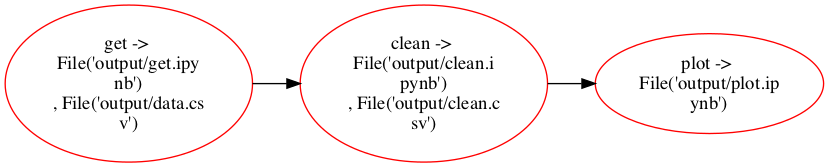

In [3]:
from IPython.display import Image
Image(filename='pipeline.png')

You can see that our pipeline has a defined execution order: `get` -> `clean` -> `plot`.

Let's now execute the `status` command, which gives us an overview of the pipeline:

In [4]:
%%bash
ploomber status

name    Last run      Outdated?    Product       Doc (short)    Location
------  ------------  -----------  ------------  -------------  ------------
get     Has not been  Source code  MetaProduct(                 /Users/Edu/d
        run                        {'data': Fil                 ev/projects-
                                   e('output/da                 ploomber/gui
                                   ta.csv'),                    des/spec-
                                   'nb': File('                 api-python/g
                                   output/get.i                 et.py
                                   pynb')})
clean   Has not been  Source code  MetaProduct(                 /Users/Edu/d
        run           & Upstream   {'data': Fil                 ev/projects-
                                   e('output/cl                 ploomber/gui
                                   ean.csv'),                   des/spec-
                                   'nb': File('  

100%|██████████| 3/3 [00:00<00:00, 3225.56it/s]


We can see a summary of each task: last execution date, if it's outdated (i.e., source code changed since previous execution), product (output files), documentation (if any), and the source code location.

## How is execution order determined?

Ploomber infers the pipeline structure from your code. For example, to
clean the data, we must get it first; hence, we declare the following in `clean.py`:

~~~python
# this tells Ploomber to execute 'get' task before 'clean'
upstream = ['get']
~~~

Once we finish cleaning the data, we must save it somewhere (In Ploomber, an output is known
as a **product**). Products can be files or SQL relations. Our current example
only generates files.

To specify where to save the output of each task, we use the `product`
key. For example, the `get` task definition looks like this:

~~~yaml
- source: get.py
  product:
    nb: output/get.ipynb
    data: output/data.csv
~~~

Scripts automatically generate a copy of themselves in Jupyter
notebook format (`.ipynb`). That's why we see a notebook in the `product`
dictionary (under the `nb` key). Generating a copy on each execution allows us to create standalone reports for each task, no need to write extra code to save our charts! Notebooks as outputs are an essential concept: `get.py` is part of the pipeline's
source code; in contrast, `output/get.ipynb` is an artifact generated by the source code.

If you don't want to generate output notebooks, you can use Python functions
as tasks. Our upcoming tutorial goes deeper into the different types of tasks.

## Building the pipeline

Let's build the pipeline:

In [5]:
%%bash
# takes a few seconds to finish
mkdir output
ploomber build

name    Ran?      Elapsed (s)    Percentage
------  ------  -------------  ------------
get     True          3.32293       37.0116
clean   True          2.09533       23.3383
plot    True          3.55981       39.6501


Building task 'plot': 100%|██████████| 3/3 [00:08<00:00,  3.00s/it]


This pipeline saves all the output in the `output/` directory; we have a few
data files:

In [6]:
%%bash
ls output/*.csv

output/clean.csv
output/data.csv


And a notebook for each script:

In [7]:
%%bash
ls output/*.ipynb

output/clean.ipynb
output/get.ipynb
output/plot.ipynb


## Updating the pipeline

Quick experimentation is essential to analyze data. Ploomber allows
you to iterate faster and run more experiments.

Say you found a problematic column and need to add few more lines to your `clean.py` script. Since `get.py` does not depend on `clean.py`, we don't have to rerun it. However, if we modify `clean.py` and want to bring our results up-to-date, we must run `clean.py`, and then `plot.py`, in that order. To save you valuable time, Ploomber keeps track of those dependencies and only reruns outdated tasks.

To see how it works, execute the following to modify the `clean.py` script

In [8]:
from pathlib import Path

path = Path('clean.py')
clean = path.read_text()
path.write_text(clean + '\nprint("hello")')

225

Let's now build again:

In [9]:
%%bash
# takes a few seconds to finish
ploomber build

name    Ran?      Elapsed (s)    Percentage
------  ------  -------------  ------------
clean   True          2.46494       39.4429
plot    True          3.78445       60.5571
get     False         0              0


Building task 'plot': 100%|██████████| 2/2 [00:06<00:00,  3.13s/it]


In [10]:
# restore contents
path.write_text(clean)

210

You'll see that `get.py` didn't run because it was not affected by the change!

Incremental builds are a powerful feature: you can open any of the `.py` files in Jupyter, edit them interactively (as if they were notebooks), then call `ploomber build` to quickly get your results up-to-date.

## Where to go from here

This tutorial shows a bit of what Ploomber can do for you. However, there are many other features to discover: task parallelization, parametrization, execution in the cloud, among others.

Want to dig deeper into Ploomber's core concepts? Check out [the basic concepts tutorial](https://ploomber.readthedocs.io/en/latest/get-started/basic-concepts.html).

Want to take a look at some examples? Check out how to [download templates](https://ploomber.readthedocs.io/en/latest/user-guide/templates.html).

Have questions? [Ask us anything on Slack](http://community.ploomber.io/) or [open an issue](https://github.com/ploomber/ploomber/issues/new?title=Question) on GitHub.

Do you like our project? Show your support with a [star on GitHub](https://github.com/ploomber/ploomber)!